In [1]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

from torchvision.models import vgg16_bn, vgg19_bn, resnet34

In [2]:
from crappify import *

In [3]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'crappy'

In [4]:
#il = ImageList.from_folder(path_hr)
#parallel(crappifier(path_lr, path_hr), il.items)

In [5]:
bs,size=32, 128
# bs,size = 24,160
#bs,size = 8,256
arch = models.resnet34

In [6]:
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [7]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [8]:
data = get_data(bs,size)

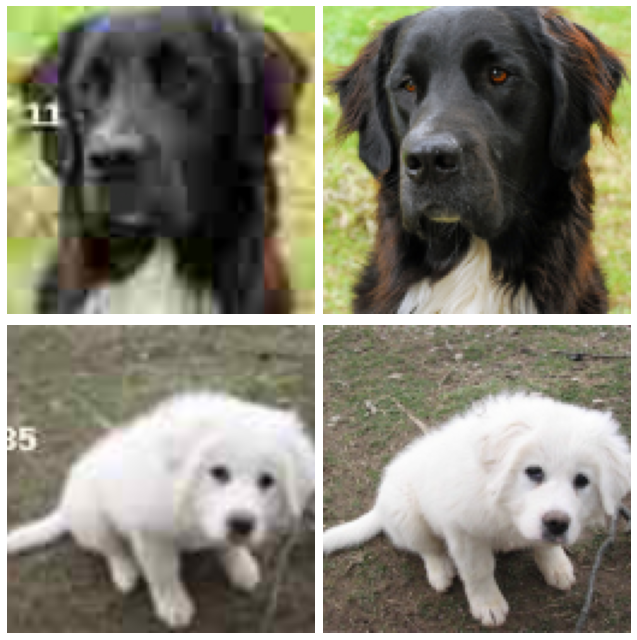

In [9]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

### Feature Loss and Gram matrix magic

In [10]:
t = data.valid_ds[0][1].data
print(t.shape)
t = torch.stack([t,t])
print(t.shape)

torch.Size([3, 128, 128])
torch.Size([2, 3, 128, 128])


In [11]:
def gram_matrix(x):
    #print(x.size())
    n,c,h,w = x.size()
    x = x.view(n, c, -1) #this reshpaes the tensor
    #print(x.size())
    x = (x @ x.transpose(1,2))/(c*h*w)
    #print(x.size())
    return x

In [12]:
#pytorch way
def gram_matrix_py(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [13]:
gram_matrix(t)


tensor([[[0.0691, 0.0695, 0.0502],
         [0.0695, 0.0708, 0.0506],
         [0.0502, 0.0506, 0.0389]],

        [[0.0691, 0.0695, 0.0502],
         [0.0695, 0.0708, 0.0506],
         [0.0502, 0.0506, 0.0389]]])

In [14]:
gram_matrix_py(t)

tensor([[0.0346, 0.0348, 0.0251, 0.0346, 0.0348, 0.0251],
        [0.0348, 0.0354, 0.0253, 0.0348, 0.0354, 0.0253],
        [0.0251, 0.0253, 0.0194, 0.0251, 0.0253, 0.0194],
        [0.0346, 0.0348, 0.0251, 0.0346, 0.0348, 0.0251],
        [0.0348, 0.0354, 0.0253, 0.0348, 0.0354, 0.0253],
        [0.0251, 0.0253, 0.0194, 0.0251, 0.0253, 0.0194]])

In [15]:
base_loss = F.l1_loss

In [26]:
print(dir(resnet34(True)))
vgg_m = resnet34(True).cuda().eval()
#vgg_m = vgg19_bn(True).features.cuda().eval()

requires_grad(vgg_m, False)

['__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_buffers', '_forward_hooks', '_forward_impl', '_forward_pre_hooks', '_get_name', '_load_from_state_dict', '_load_state_dict_pre_hooks', '_make_layer', '_modules', '_named_members', '_norm_layer', '_parameters', '_register_load_state_dict_pre_hook', '_register_state_dict_hook', '_replicate_for_data_parallel', '_save_to_state_dict', '_slow_forward', '_state_dict_hooks', '_version', 'add_module', 'apply', 'avgpool', 'base_width', 'bn1', 'buffers', 'children', 'conv1', 'cpu', 'cuda', 'dilation', 'double', 'dump_patches', 'eval', 'extra_repr', 'fc', 'float', 'forward', 'groups', '

In [27]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

TypeError: 'ResNet' object is not subscriptable

In [ ]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [ ]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

### Train with new loss function

In [ ]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)
gc.collect();

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr = 1e-3

In [ ]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)

In [ ]:
do_fit('1a', slice(lr*10))

In [ ]:
learn.unfreeze()

In [ ]:
do_fit('1b', slice(1e-5,lr))

In [ ]:
data = get_data(12,size*2)

In [ ]:
learn.data = data
learn.freeze()
gc.collect()

In [ ]:
learn.load('1b');

In [ ]:
do_fit('2a')

epoch	train_loss	valid_loss	pixel	feat_0	feat_1	feat_2	gram_0	gram_1	gram_2	time

0	2.340232	2.339063	0.184695	0.274836	0.310050	0.162608	0.401680	0.617106	0.388088	08:01

In [ ]:
learn.save('2a')

In [ ]:
learn.unfreeze()

In [ ]:
do_fit('2b', slice(1e-6,1e-4), pct_start=0.3)

### With Fast AI Gram function and vgg16_bn 
epoch	train_loss	valid_loss	pixel	feat_0	feat_1	feat_2	gram_0	gram_1	gram_2	time
0	2.193930	2.198517	0.184008	0.270482	0.299086	0.154482	0.350994	0.574527	0.364939	07:26
1	2.186902	2.196501	0.183511	0.269964	0.298685	0.154364	0.351907	0.573608	0.364463	07:25
2	2.194870	2.195276	0.183459	0.270050	0.298700	0.154113	0.351474	0.573473	0.364006	07:25
3	2.189421	2.190201	0.184658	0.269990	0.298061	0.153955	0.348896	0.571289	0.363351	07:25
4	2.167092	2.187832	0.184521	0.269993	0.298060	0.153625	0.348432	0.570778	0.362424	07:25
5	2.171011	2.187572	0.183833	0.270077	0.298211	0.153457	0.348336	0.571823	0.361835	07:25
6	2.176027	2.183954	0.184266	0.270100	0.297898	0.153284	0.347669	0.569482	0.361255	07:26
7	2.184815	2.181681	0.183983	0.269880	0.297763	0.153238	0.347291	0.568295	0.361231	07:25
8	2.174898	2.181092	0.185062	0.270414	0.297777	0.153265	0.345557	0.567885	0.361132	07:25
9	2.179365	2.180668	0.183658	0.269810	0.297563	0.153143	0.347073	0.568269	0.361152	07:25

### With Fast AI Gram function and vgg19_bn 
epoch	train_loss	valid_loss	pixel	feat_0	feat_1	feat_2	gram_0	gram_1	gram_2	time
0	2.308309	2.286349	0.184552	0.268176	0.326589	0.153075	0.333802	0.650663	0.369493	07:51
1	2.309063	2.282637	0.185408	0.268549	0.326612	0.153191	0.330760	0.648506	0.369613	07:50
2	2.305078	2.281155	0.185122	0.268485	0.326322	0.152777	0.331888	0.647857	0.368703	07:50
3	2.299894	2.277680	0.185134	0.267814	0.325665	0.152357	0.331513	0.647178	0.368019	07:50
4	2.297771	2.273708	0.185591	0.267994	0.325732	0.152303	0.328634	0.645662	0.367793	07:50
5	2.298440	2.270436	0.185370	0.268217	0.325492	0.152182	0.327799	0.644205	0.367172	08:17
6	2.280966	2.268376	0.184828	0.267558	0.324981	0.151739	0.328941	0.644015	0.366314	08:23
7	2.293021	2.267448	0.184850	0.267788	0.325059	0.151721	0.328628	0.643365	0.366038	08:23
8	2.298039	2.266399	0.184754	0.267647	0.325162	0.151643	0.327961	0.643196	0.366037	08:23
9	2.275104	2.267569	0.185377	0.268119	0.325274	0.151655	0.327911	0.643215	0.366017	08:23